In [2]:
!pip install pytorch_lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 825.8/825.8 KB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 517.2/517.2 KB 18.5 MB/s eta 0:00:00


In [3]:
import pytorch_lightning as pl
import torchvision.models as models
import torch
import torch.nn as nn

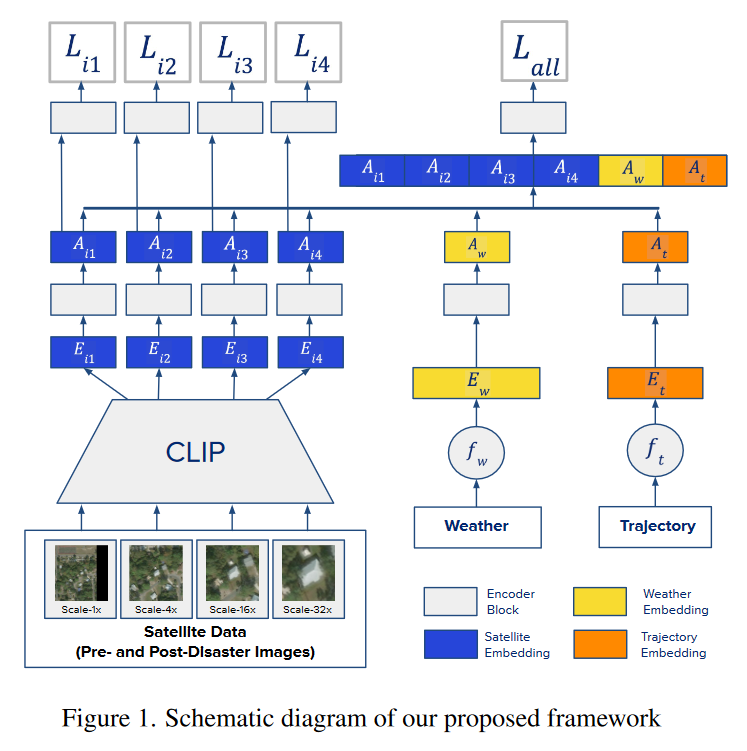

In [ ]:
"""A data augmentation class"""

class DataAugmentation(nn.Module):
    """Module to perform data augmentation on torch tensors."""
    """Consider using the augmentations in the below link, as they work on tensors"""
    """https://pytorch.org/vision/main/transforms.html"""

    def __init__(self,
                 noise_amount = 0,
                 rotation_amount = 0.5,
                 flip_probability = 0.5,
                 ...) -> None:
        super().__init__()
        
        self.apply_noise = apply_noise

        self.flipping = nn.Sequential(
            RandomHorizontalFlip(p = flip_probability),
            RandomVerticalFlip(p = flip_probability)
        )

        self.rotation = RandomRotation(rotation_amount)

        self.noise = GaussianNoise(noise_amount)

    @torch.no_grad()  # disable gradients for effiency
    def forward(self, x: Tensor) -> Tensor:
        x = self.flipping(x)

        if self.apply_noise > 0:
            x = self.apply_noise(x)

        x = self.rotation(x)

        return x

"""initialize the image embedding block"""
"""in GaLeNet Fig.1 this is the CLIP box"""
class ImageEncoder(pl.LightningModule):
    def __init__(self, image_embedding_architecture, image_encoder_lr):
        super().__init__()

        # tell pytorch to use the ResNet50 architecture
        if image_embedding_architecture = "ResNet50":
            backbone = models.resnet50()

        if image_embedding_architecture = "CLIP":
            # backbone = load ViT-L/14@336p CLIP model

        layers = list(backbone.children())
        self.feature_extractor = nn.Sequential(*layers)

    def forward(self, x):
        """if image_encoder_lr == 0, then freeze the weights"""
        self.feature_extractor.eval()

        with torch.no_grad():
            embedding = self.feature_extractor(x).flatten(1)

        return embedding


"""initalize the generic encoder block"""
"""in GaLeNet Fig.1 this is all of the small grey Encoder Blocks"""
class GenericEncoder(pl.LightningModule):
    def __init__(self, num_input_features, num_output_features, dropout_rate): 
        super().__init__()

        self.l1 = nn.Linear(num_input_features, num_output_features)
        self.batchnorm = nn.BatchNorm1d(num_output_features)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = self.l1(x)
        x = self.batchnorm(x)
        x = torch.relu(x)
        x = self.dropout(x)

        return x


"""initalize the SoftMax classification layer to predict damage class"""
"""This is not in the figure, but is used after the final GenericEncoder block"""
class ClassificationLayer(pl.LightningModule):
    def __init__(self, num_input_features): 
        super().__init__()

        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.softmax(x)

        return x

"""initalize the overall architecture, i.e. the combination of encoder blocks"""
class OverallModel(pl.LightningModule):
    def __init__(
        self,
        image_embedding_architecture: string = "ResNet50",
        dropout_rate: float = 0.2,
        generic_encoder_lr: float = 1e-4,
        image_encoder_lr: float = 0,
        batch_size = 32
    ) -> None:
        super().__init__()

        self.augment = DataAugmentation()

        self.image_encoder = ImageEncoder(
            image_embedding_architecture, image_encoder_lr
        )

        """below, num_input_features should be some parameter that contains the number of weather related features"""
        self.weather_encoder = GenericEncoder(
            num_input_features, num_output_features, dropout_rate  
        )

        """below, num_input_features should be some parameter that contains the number of DEM related features"""
        self.dem_encoder = GenericEncoder(
            num_input_features, num_output_features, dropout_rate  
        )

        """there will be one storm surge feature. how, if at all, should this be encoded?"""
        self.storm_surge_encoder = GenericEncoder(
            num_input_features, num_output_features, dropout_rate  
        )

        """... more EF encoders"""

        """this encoder operates on the concatenated feature vectors"""
        """GaLeNet has num_input_features = 243 for this encoder"""
        self.concat_encoder = GenericEncoder(
            num_input_features, num_output_features, dropout_rate  
        )

        self.image_encoder_lr = image_encoder_lr
        self.generic_encoder_lr = generic_encoder_lr
        self.batch_size = batch_size
        self.dropout_rate = dropout_rate


        self.save_hyperparameters()


    def forward(self, inputs):
        """for each zoom level Z, do image_Z_embedding = self.image_encoder(inputs["image_Z"], image_embedding_architecture)"""

        """for each zoom level Z, do image_Z_embedding = self.GenericEncoder(image_Z_embedding, num_input_features, num_output_features)"""


        """for each type of EF, do EF_embedding = self.image_encoder(inputs["EF"])"""
        """all related EFs (e.g. all the weather EFs) should be in a
        single vector and pushed through a single embedding block."""
        """there should be a different embedding block for each type of EF"""

        """concat_embedding = concat all EF_embeddings and all image_Z_embeddings"""
        """concat_embedding = GenericEncoder(concat_embedding)"""
        """concat_prediction = self.ClassificationLayer(concat_prediction)"""

        """for each zoom level Z, do Z_prediction = self.ClassificationLayer(image_Z_embedding)"""


        """return the predictions from each zoom level individually and also the 
        predciction from the concat_embedding"""
        return Z1_prediction, Z2_prediction, ..., concat_prediction


    def _compute_losses(self, Z1_prediction, Z2_prediction, ..., concat_prediction, y):
        """Z1_loss = focal_loss(Z1_prediction, y)"""
        """Z2_loss = focal_loss(Z2_prediction, y)"""
        """..."""
        """concat_loss = focal_loss(concat_loss, y)"""

        """loss = sum(Z1_loss to Z4_loss) + concat_loss"""
        """each of the individual loss functions is a torchvision.ops.focal_loss, as in GaLeNet"""
        """the L_i's correspond to different zoom levels, so only use one L_i to start with"""
        return loss


    def configure_optimizers(self):
        """for now, when image_encoder_lr = 0, freeze the weights of ImageEncoder"""
        """figure out how to apply different lr to the image encoder and to the
        generic encoders"""
        optimizer = optim.Adam(parameters, weight_decay=self.weight_decay)
        lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            optimizer,
            mode="min",
            patience=self.lr_scheduler_patience,
            factor=self.lr_scheduler_factor,
        )
        return {
            "optimizer": optimizer,
            "lr_scheduler": lr_scheduler,
            "monitor": "val/loss",
        }


    def training_step(self, batch, *args, **kwargs):
        x, y = next(iter(self.train_dataloader()))
        x = self.augment(x)
        Z1_prediction, Z2_prediction, ..., concat_prediction = self.forward(x)
        loss = self._compute_losses(Z1_prediction, Z2_prediction, ..., concat_prediction, y).mean() # maybe normalize the loss?
        train_loss = self.all_gather(loss) # what does all_gather do?
        self.log("train/loss", train_loss.mean())
        return loss


    def validation_step(self, batch, *args, **kwargs):
        x, y = next(iter(self.val_dataloader()))
        Z1_prediction, Z2_prediction, ..., concat_prediction = self.forward(x)
        loss = self._compute_losses(Z1_prediction, Z2_prediction, ..., concat_prediction, y).mean()
        val_loss = self.all_gather(loss)
        self.log("val/loss", val_loss.mean())
        return loss

    """these dataloaders should ideally produce x in such a way that you can e.g. do 
    x["Weather"] and get a vector that contains all weather related EFs, and also
    x["image"] to get a tensor"""
    """see https://pytorch-lightning.readthedocs.io/en/stable/guides/data.html"""
    def train_dataloader(self):
        loader = DataLoader(dataset, batch_size = self.batch_size)
        return loader

    def val_dataloader(self):
        loader = DataLoader(dataset, batch_size = self.batch_size)
        return loader

model = OverallModel() # put arguments in here, e.g. batch_size = 64
model.train()